# With LangChain Agents

In [2]:
from langchain.agents import initialize_agent, Tool
from langchain.agents.agent_types import AgentType
from langchain.chains.retrieval_qa.base import RetrievalQA
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter

In [3]:
# Step 1: Load and split documents
loader = TextLoader("The_Complete_Guide_to_Flower_Language.txt")
docs = loader.load()
splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = splitter.split_documents(docs)

In [5]:
# Step 2: Create retriever
from dotenv import load_dotenv
load_dotenv()


embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embedding)
retriever = vectorstore.as_retriever()

In [9]:
# Step 3: Create RAG tool (retriever + LLM)
llm = ChatOpenAI(temperature=0)
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
retrieval_tool = Tool.from_function(
    func=rag_chain.run,
    name="FlowerDocQA",
    description="Use this to answer flower-related questions from the guidebook."
)


In [10]:
# Step 4: Initialize agent with the tool
agent = initialize_agent(
    tools=[retrieval_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


C:\Users\JMY\AppData\Local\Temp\ipykernel_3124\2662901114.py:2: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [12]:
# Step 5: Ask the agent
question = "What do roses symbolize, and how do people usually gift them?"
agent.invoke(question)



> Entering new AgentExecutor chain...
I should use FlowerDocQA to find out the symbolic meaning of roses and how people typically gift them.
Action: FlowerDocQA
Action Input: "What do roses symbolize and how do people usually gift them?"
Observation: Roses symbolize love. People often gift roses to express their love and affection towards someone special, especially on occasions like Valentine's Day, anniversaries, or to convey romantic feelings.
Thought:I now know the final answer
Final Answer: Roses symbolize love, and people usually gift them to express their love and affection towards someone special.

> Finished chain.


{'input': 'What do roses symbolize, and how do people usually gift them?',
 'output': 'Roses symbolize love, and people usually gift them to express their love and affection towards someone special.'}

# With LangGraph Agents

In [13]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph
from langchain.agents import Tool
from langchain.chains import RetrievalQA
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import CharacterTextSplitter


In [14]:
# 1. Load documents and create retriever
loader = TextLoader("The_Complete_Guide_to_Flower_Language.txt")
docs = loader.load()
splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = splitter.split_documents(docs)
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embedding)
retriever = vectorstore.as_retriever()

In [15]:
# 2. Create a RetrievalQA tool
llm = ChatOpenAI(temperature=0)
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
tool = Tool.from_function(
    func=rag_chain.run,
    name="FlowerDocQA",
    description="Use this to answer flower-related questions from the guidebook."
)

In [34]:
agent_node = create_react_agent(
    model=llm,
    tools=tools
)

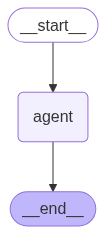

In [35]:
# 4. Define the graph
from typing import TypedDict, List
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: List[BaseMessage]  # required for LangGraph ReAct agent


graph = StateGraph(AgentState)
graph.add_node("agent", agent_node)
graph.set_entry_point("agent")


app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [39]:
from langchain_core.messages import HumanMessage

response = app.invoke({
    "messages": [HumanMessage(content="What do roses symbolize?")]
})

print(response["messages"][-1].content)

# from langchain_core.messages import AIMessage

# response = app.invoke({
#     "messages": [HumanMessage(content="What do roses symbolize and how are they typically gifted?")]
# })

# # Extract reasoning steps
# for msg in response["messages"]:
#     if isinstance(msg, AIMessage):
#         print(msg.content)

Roses symbolize love, friendship, and joy. Red roses symbolize love, while yellow roses symbolize friendship and joy.
